In [1]:
library(tidyverse)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.3     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


In [71]:
library(tidymodels)

── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.4     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks readr::spec()
✖ recipes::step()   masks stats::step()
• Search for functions across packages at https://www.tidymodels.org/find/



In [77]:
set.seed(3)

Group members: Jiaming Chang, Charmaine Ma, Ewan Painter, Yang Wang

Introduction

This project focuses on Men's College Basketball in the US, specifically pertaining to the NCAA tournament or March Madness. This tournament is interesting to study because of its high variance compared to other major sports. Its variance can be attributed to two major factors. Firstly, the tournament draws its pool of 68 teams from the current 363 Division I schools. Many top teams never play each other in their season leading up to the tournament. Some top teams that gain entry into the tournament by winning a smaller conference championship and never play any top team in their season. Due to this, it becomes difficult to evaluate the relative strength of teams and predict individual matchups. The second factor that makes matchups difficult to predict is that each round of the tournament is a best of 1 (in comparison, professional basketball playoff series are a best of 7), further enabling upsets and unpredictability. Our project will test how truly random these results are, or if a common theme can be established amongst successful teams in the tournament. Our dataset includes comprehensive statistics for all NCAA tournament teams from 2013 to 2021 as well as their seed in the tournament and the round of the tournament they reached.

Preliminary Data Analysis

In [78]:
cbb <- read_csv("https://raw.githubusercontent.com/naw333/College-Basketball-Data-Science/main/cbb.csv")
head(cbb,n=3)

Rows: 3523 Columns: 24
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (4): TEAM, CONF, POSTSEASON, SEED
dbl (20): G, W, ADJOE, ADJDE, BARTHAG, EFG_O, EFG_D, TOR, TORD, ORB, DRB, FT...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


TEAM,CONF,G,W,ADJOE,ADJDE,BARTHAG,EFG_O,EFG_D,TOR,⋯,FTRD,2P_O,2P_D,3P_O,3P_D,ADJ_T,WAB,POSTSEASON,SEED,YEAR
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
North Carolina,ACC,40,33,123.3,94.9,0.9531,52.6,48.1,15.4,⋯,30.4,53.9,44.6,32.7,36.2,71.7,8.6,2ND,1,2016
Wisconsin,B10,40,36,129.1,93.6,0.9758,54.8,47.7,12.4,⋯,22.4,54.8,44.7,36.5,37.5,59.3,11.3,2ND,1,2015
Michigan,B10,40,33,114.4,90.4,0.9375,53.9,47.7,14.0,⋯,30.0,54.7,46.8,35.2,33.2,65.9,6.9,2ND,3,2018


In [84]:
cbb_split <- initial_split(cbb, prop = 0.75, strata = POSTSEASON)
cbb_train <- training(cbb_split)
cbb_test <- testing(cbb_split)

In [73]:
## Table shows number of teams in the dataset as well as averages for important metrics.

cbb_summ <- summarize(cbb_train, team_count = nrow(cbb_train), mean_ADJOE = mean(ADJOE), mean_ADJDE = mean(ADJDE), mean_ADJ_T = mean(ADJ_T), mean_ORB = mean(ORB), mean_TOR = mean(TOR), mean_W = mean(W))
cbb_summ

team_count,mean_ADJOE,mean_ADJDE,mean_ADJ_T,mean_ORB,mean_TOR,mean_W
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2642,103.0879,103.2634,67.69425,29.30303,18.7162,15.89478


`geom_smooth()` using formula = 'y ~ x'


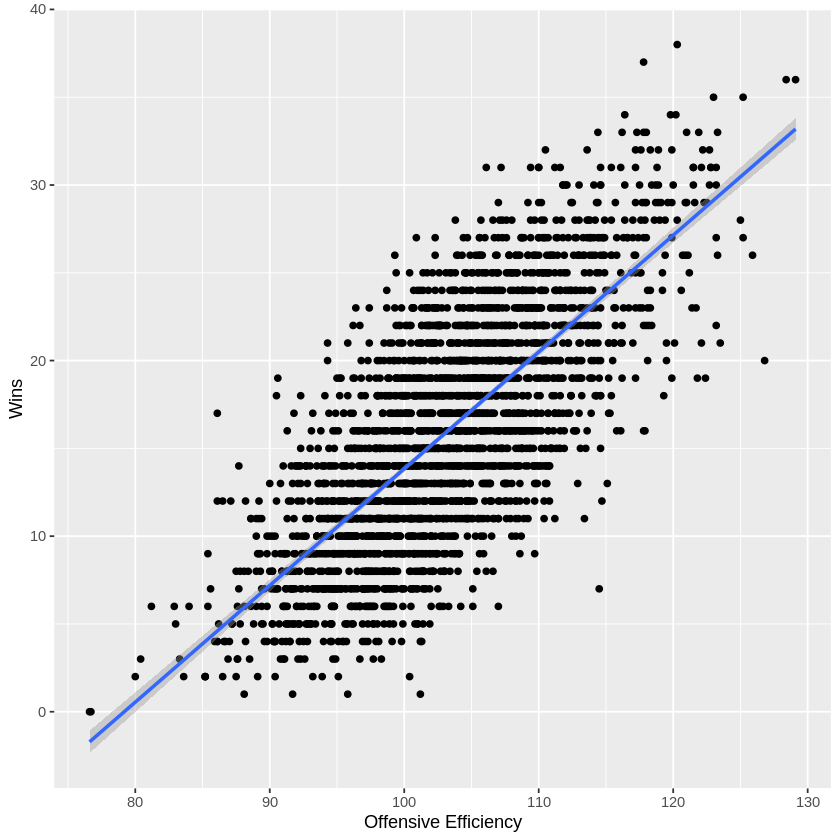

In [74]:
## Graph shows relationship between a team's regular season wins and its number of points scored per possession.

ggplot(cbb_train, aes(x = ADJOE, y = W)) +
  geom_point() +
  geom_smooth(method=lm) +
  labs(x = "Offensive Efficiency",
       y = "Wins")

Methods

To perform the data analysis, a K nearest neighbors classifier will be used to classify the team’s POSTSEASON (round where the observed team’s season ended) based on the predictor variables: ADJOE, ADJDE, ORB, 3P_O, ADJ_T, TOR, G, and W (Adjusted Offensive Efficiency, Adjusted Defensive Efficiency, Offensive Rebound Rate, Three-Point Shooting Percentage, Adjusted Tempo, Turnover Rate, Number of games played, and Number of games won respectively). The basketball data set is split into training and testing sets, which will be used to train the classifier and evaluate the classifier’s performance. The training set will be used to perform a 5-fold cross-validation to select the k value that optimizes the classifier’s performance based on the accuracy of the classifier. The performance of the classifier will be tested using the test set, then a new set of observations for basketball teams will be classified using the trained classifier. The correlation coefficient will be calculated between each predictor variable and POSTSEASON, and the result of this will be visualized as a bar graph.

Expected Outcomes

What do you expect to find?
Generally, we expect strength in defensive variables to be a greater indicator of success as opposed to offensive variables.
What impact could such findings have?
Uncovering key metrics can guide team strategy and enhance analysts' tournament predictions.
What future questions could this lead to? 
-Individual Player Metrics: Can individual stats offer deeper insights into team strengths? 
-Matchup Predictability: Can the classifier predict specific game outcomes, especially potential upsets? 
-Metric Evolution: As basketball evolves, how does the significance of certain metrics change? 
-External Factors: What other factors, like morale or injuries, influence success, and can they be incorporated for improved predictions?